## Creating a training dataset

In [1]:
# Common Python libraries
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# For reading in images and image manipulation
import cv2

# For label encoding the target variable
from sklearn.preprocessing import LabelEncoder

# For tensor based operations
from tensorflow.keras.utils import to_categorical, normalize

# For Machine Learning
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

# For face detection
from mtcnn.mtcnn import MTCNN

In [2]:
# Reading in the csv file
train = pd.read_csv("train.csv")
# Displaying the first five rows
train.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
2,2756.png,75,252,264,390,mask_colorful
3,2756.png,521,136,711,277,mask_colorful
4,6098.jpg,360,85,728,653,face_no_mask


In [3]:
# Total number of unique images
print(len(train["name"].unique()))
print(train["name"].unique())

4326
['2756.png' '6098.jpg' '6427.png' ... '2460.png' '1894.jpg' '3216.png']


In [4]:
print(len(train["classname"].unique()))
print(train["classname"].unique())

20
['face_with_mask' 'mask_colorful' 'face_no_mask'
 'face_with_mask_incorrect' 'mask_surgical' 'face_other_covering'
 'scarf_bandana' 'eyeglasses' 'helmet' 'face_shield' 'sunglasses' 'hood'
 'hat' 'goggles' 'hair_net' 'hijab_niqab' 'other' 'gas_mask'
 'balaclava_ski_mask' 'turban']


In [5]:
# classnames to select
options = ["face_with_mask", "face_no_mask"]

# Select rows that have the classname as either "face_with_mask" or "face_no_mask"
train = train[train["classname"].isin(options)]
train.sort_values("name", axis=0, inplace=True)
train = train.reset_index(drop=True)

In [6]:
print(train)

          name   x1   x2   y1   y2       classname
0     1801.jpg  451  186  895  697    face_no_mask
1     1802.jpg  110   71  273  272  face_with_mask
2     1803.jpg  126   75  303  333  face_with_mask
3     1804.jpg  112  113  262  307  face_with_mask
4     1805.jpg  728  180  853  336  face_with_mask
...        ...  ...  ...  ...  ...             ...
5744  6433.png  669  105  798  281  face_with_mask
5745  6433.png  765  142  976  364  face_with_mask
5746  6433.png  536  152  665  333  face_with_mask
5747  6433.png  146  107  304  313  face_with_mask
5748  6434.jpg  315   82  775  783  face_with_mask

[5749 rows x 6 columns]


<BarContainer object of 2 artists>

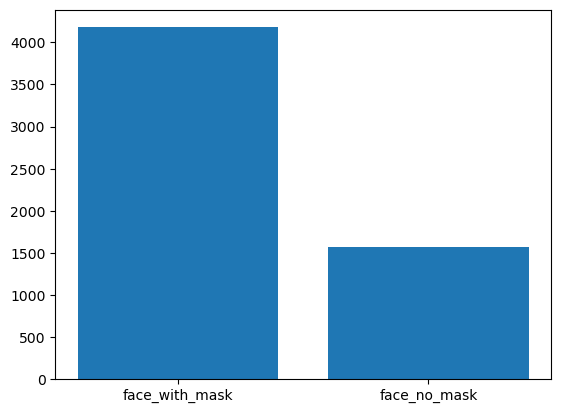

In [7]:
# Plotting a bar plot
# Biased towards face with masks
x_axis_val = ["face_with_mask", "face_no_mask"]
y_axis_val = train.classname.value_counts()
plt.bar(x_axis_val, y_axis_val)

1569
1569
3138


<BarContainer object of 2 artists>

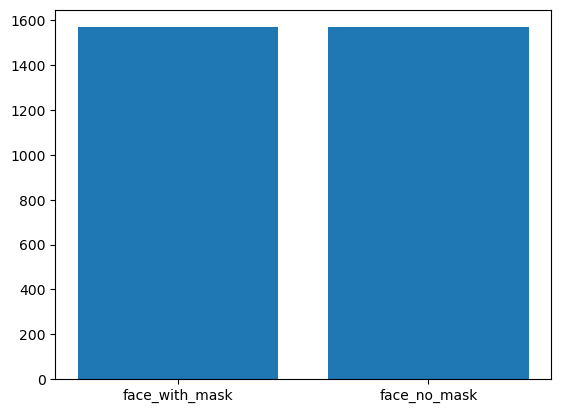

In [8]:
# removed some records to havev equal number of images with/without masks 
mask_off = train[train["classname"]=="face_no_mask"]
mask_on = train[train["classname"]=="face_with_mask"].iloc[:1569]
final = pd.merge(mask_off, mask_on, how = 'outer')

# printing the count of each dataframe
print(len(mask_off))
print(len(mask_on))
print(len(final))

# Plotting a bar plot (equal biasing)
x_axis_val = ["face_with_mask", "face_no_mask"]
y_axis_val = final.classname.value_counts()
plt.bar(x_axis_val, y_axis_val)

In [9]:
# Contains images of medical masks
images_file_path = "Medical Mask\Medical Mask\Medical Mask\images\\"

# Fetching all the file names in the image directory
image_filenames = os.listdir(images_file_path)

# Printing out the first five image names
print(image_filenames[:5])

['0001.jpg', '0002.png', '0003.jpg', '0004.jpg', '0005.jpg']


[[451, 186, 895, 697]]


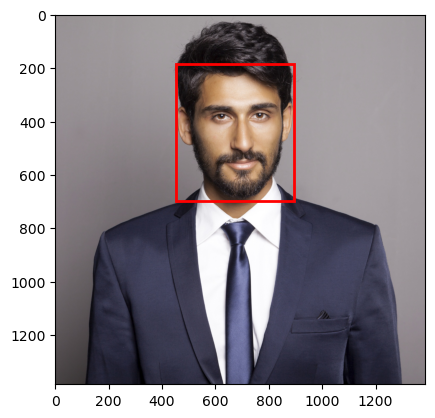

In [10]:
# Getting the full image filepath
sample_image_name = final.iloc[0]["name"]
sample_image_file_path = images_file_path + sample_image_name

# Select rows with the same image name as in the "name" column of the train dataframe
sel_df = final[final["name"] == sample_image_name]

# Convert all of the available "bbox" values into a list
bboxes = sel_df[["x1", "x2", "y1", "y2"]].values.tolist()
print(bboxes)

# Creating a figure and a sub-plot
fig, ax = plt.subplots()

# Reading in the image as an array
img = plt.imread(sample_image_file_path)

# Showing the image
ax.imshow(img)

# Plotting the bounding boxes
for box in bboxes:

    x1, x2, y1, y2 = box

    # x and y co-ordinates
    xy = (x1, x2)

    # Width of box
    width = y1 - x1

    # Height of box
    height = y2 - x2

    rect = patches.Rectangle(
        xy,
        width,
        height,
        linewidth=2,
        edgecolor="r",
        facecolor="none",
    )

    ax.add_patch(rect)

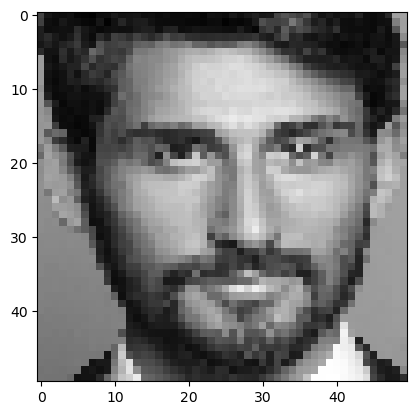

In [11]:
img_size = 50
data = []

for index, row in final.iterrows():

    # Single row
    name, x1, x2, y1, y2, classname = row.values

    # Full file path
    full_file_path = images_file_path + name

    # Reading in the image array as a grayscale image
    img_array = cv2.imread(full_file_path, cv2.IMREAD_GRAYSCALE)

    # Selecting the portion covered by the bounding box
    crop_image = img_array[x2:y2, x1:y1]

    # Resizing the image
    new_img_array = cv2.resize(crop_image, (img_size, img_size))

    # Appending the arrays into a data variable along with bounding box
    data.append([new_img_array, classname])

# Plotting one of the images after pre-processing
plt.imshow(data[0][0], cmap="gray")

In [12]:
# Initializing an empty list for features (independent variables)
x = []

# Initializing an empty list for labels (dependent variable)
y = []
for features, labels in data:
    x.append(features)
    y.append(labels)

In [13]:
# Reshaping the feature array (Number of images, IMG_SIZE, IMG_SIZE, Color depth)
x = np.array(x).reshape(-1, 50, 50, 1)

# Normalizing
x = normalize(x, axis=1)

# Label encoding y
# This is done for encoding face maks - yes/no
# face_no_mask = [1. 0.] and face_with_mask = [0. 1.]
lbl = LabelEncoder()
y = lbl.fit_transform(y)

# Converting it into a categorical variable
y = to_categorical(y)

In [14]:
x[0].min(),x[0].max()

(0.006336624000624299, 0.3133853673620512)

In [15]:
print(y[:5])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


## Training an Image Classification Model

In [16]:
x.shape

(3138, 50, 50, 1)

In [17]:
input_img_shape = x.shape[1:]
print(input_img_shape)

(50, 50, 1)


In [18]:
# Initializing a sequential keras model
model = Sequential()

# Adding a 2D convolution layer
model.add(
    Conv2D(
        filters=100,
        kernel_size=(3, 3),
        use_bias
        =True,
        input_shape=input_img_shape,
        activation="relu",
        strides=2,
    )
)

# Adding a max-pooling layer
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a 2D convolution layer - Output Shape = 10 x 10 x 64
model.add(Conv2D(filters=64, kernel_size=(3, 3), use_bias=True, activation="relu"))

# Adding a max-pooling layer - Output Shape = 5 x 5 x 64
model.add(MaxPooling2D(pool_size=(2, 2)))

# Adding a flatten layer - Output Shape = 5 x 5 x 64 = 1600
model.add(Flatten())

# Adding a dense layer - Output Shape = 50
model.add(Dense(50, activation="relu"))

# Adding a dropout
model.add(Dropout(0.2))

# Adding a dense layer with softmax activation
model.add(Dense(2, activation="softmax"))

# Printing the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 100)       1000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 12, 12, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 64)        57664     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 50)                8

In [20]:
# Initializing an Adam optimizer
opt = Adam(learning_rate=1e-3, decay=1e-5)

# Configuring the model for training
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# Training the model
model.fit(x, y, epochs=30, batch_size=5)

Epoch 1/30
628/628 [==============================] - 7s 9ms/step - loss: 0.0611 - accuracy: 0.9764
Epoch 2/30
628/628 [==============================] - 6s 9ms/step - loss: 0.0559 - accuracy: 0.9790
Epoch 3/30
628/628 [==============================] - 5s 8ms/step - loss: 0.0437 - accuracy: 0.9828
Epoch 4/30
628/628 [==============================] - 5s 8ms/step - loss: 0.0643 - accuracy: 0.9767
Epoch 5/30
628/628 [==============================] - 5s 8ms/step - loss: 0.0531 - accuracy: 0.9802
Epoch 6/30
628/628 [==============================] - 5s 8ms/step - loss: 0.0417 - accuracy: 0.9850
Epoch 7/30
628/628 [==============================] - 5s 8ms/step - loss: 0.0324 - accuracy: 0.9898
Epoch 8/30
628/628 [==============================] - 5s 8ms/step - loss: 0.0424 - accuracy: 0.9850
Epoch 9/30
628/628 [==============================] - 5s 8ms/step - loss: 0.0372 - accuracy: 0.9866
Epoch 10/30
628/628 [==============================] - 5s 8ms/step - loss: 0.0383 - accuracy: 0.9882

## Making a prediction

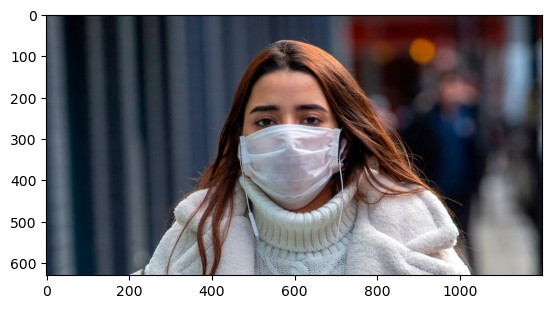

In [23]:
# Image file path for sample image
test_image_file_path = r"C:\Users\vshri\OneDrive\Desktop\Shruti\Engg Application\5_ShivNadar\Study Material\Programs\LMS Submissions_ZipFiles\Sem_III\Mini Project\Medical mask\Medical mask\Medical Mask\images\0055.jpg"

# Loading in the image
img = plt.imread(test_image_file_path)

# Showing the image
plt.imshow(img)

In [24]:
# Initializing the detector
detector = MTCNN()

# Detecting the faces in the image
faces = detector.detect_faces(img)

print(faces)

1/1 [==============================] - 0s 313ms/step
[{'box': [480, 135, 223, 277], 'confidence': 0.9997296333312988, 'keypoints': {'left_eye': (536, 259), 'right_eye': (645, 247), 'nose': (595, 298), 'mouth_left': (562, 358), 'mouth_right': (646, 347)}}]


1/1 [==============================] - 0s 289ms/step


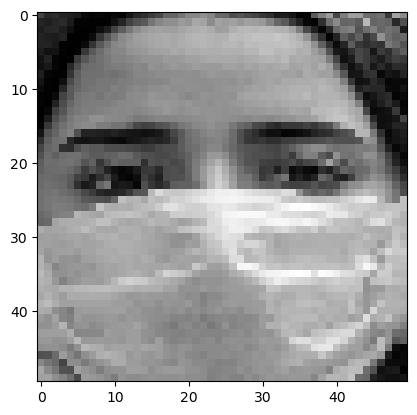

In [25]:
# Reading in the image as a grayscale image
img_array = cv2.imread(test_image_file_path, cv2.IMREAD_GRAYSCALE)

# Initializing the detector
detector = MTCNN()

# Detecting the faces in the image
faces = detector.detect_faces(img)

# Getting the values for bounding box
x1, x2, width, height = faces[0]["box"]

# Selecting the portion covered by the bounding box
crop_image = img_array[x2 : x2 + height, x1 : x1 + width]

# Resizing the image
new_img_array = cv2.resize(crop_image, (img_size, img_size))

# Plotting the image
plt.imshow(new_img_array, cmap="gray")

In [26]:
# Reshaping the image
x = new_img_array.reshape(-1, 50, 50, 1)

# Normalizing
x = normalize(x, axis=1)

In [27]:
prediction = model.predict(x)
print(prediction)

1/1 [==============================] - 0s 134ms/step
[[7.1874215e-14 1.0000000e+00]]


In [28]:
if (prediction[0][0]) < (prediction[0][1]):
    print("Mask detected.")
else:
    print("Mask not detected.")

Mask detected.


## sample testing

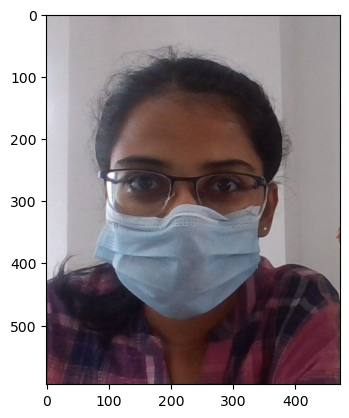

In [29]:
# Image file path for sample image
test_image_file_path1 = "0003.jpg"

# Loading in the image
img1 = plt.imread(test_image_file_path1)

# Showing the image
plt.imshow(img1)

In [30]:
# Initializing the detector
detector1 = MTCNN()

# Detecting the faces in the image
faces1 = detector1.detect_faces(img1)

print(faces1)

1/1 [==============================] - 0s 301ms/step
[{'box': [83, 131, 277, 331], 'confidence': 0.9995998740196228, 'keypoints': {'left_eye': (162, 271), 'right_eye': (290, 270), 'nose': (222, 342), 'mouth_left': (171, 390), 'mouth_right': (276, 390)}}]


1/1 [==============================] - 1s 643ms/step


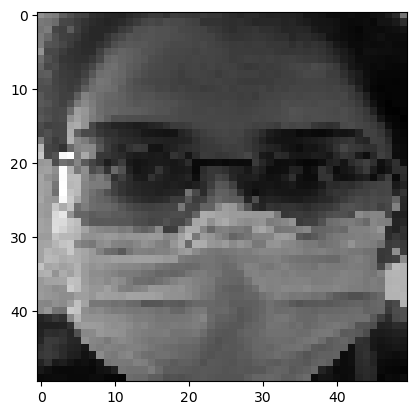

In [31]:
# Reading in the image as a grayscale image
img_array1 = cv2.imread(test_image_file_path1, cv2.IMREAD_GRAYSCALE)

# Initializing the detector
detector1 = MTCNN()

# Detecting the faces in the image
faces1 = detector1.detect_faces(img1)

# Getting the values for bounding box
x1, x2, width, height = faces1[0]["box"]

# Selecting the portion covered by the bounding box
crop_image1 = img_array1[x2 : x2 + height, x1 : x1 + width]

# Resizing the image
new_img_array1 = cv2.resize(crop_image1, (img_size, img_size))

# Plotting the image
plt.imshow(new_img_array1, cmap="gray")

In [32]:
# Reshaping the image
a = new_img_array1.reshape(-1, 50, 50, 1)

# Normalizing
a = normalize(a, axis=1)

In [33]:
prediction1 = model.predict(a)
print(prediction1)

1/1 [==============================] - 0s 28ms/step
[[2.301478e-11 1.000000e+00]]


In [34]:
print(type(prediction1))

<class 'numpy.ndarray'>


In [35]:
if (prediction1[0][0]) < (prediction1[0][1]):
    print("Mask detected.")
else:
    print("Mask not detected.")

Mask detected.
